Probability Distributions and An Introduction to Simulation
====

Statistical inference essentially consists of fitting probability distributions to data. So learning how to summarize, fit and draw samples from probability distributions is foundational to understanding how to apply statistics to HTS data sets.

In [1]:
library(ggplot2)

In [2]:
options(repr.plot.width=4, repr.plot.height=3)

Working with distributions - the `d`, `p`, `q`, `r` family
----

- `d` density
- `p` cumulative distribution
- `q` quantile
- `r` random samples

We will illustrate by using a normal distribution example how these functions are used.

### Example: IQ model

We assume that IQ in a population has a normal distribuiton with mean = 100 and standard deviation = 15. 

#### Plot the density function with `dnorm`

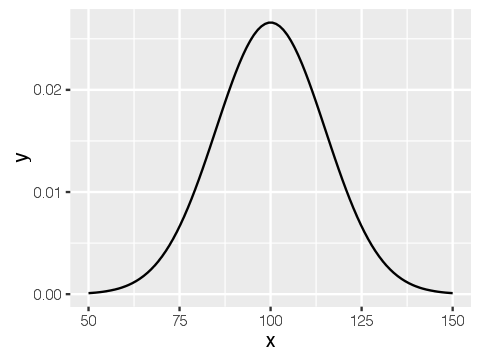

In [3]:
x <- seq(50, 150, length.out = 100)
y <- dnorm(x, mean = 100, sd = 15)
df <- data.frame(x=x, y=y)
ggplot(df, aes(x=x, y=y)) + geom_line()

### Use `pnrorm` to find what fraction of the population has IQ > 120

In [4]:
round(1 - pnorm(q=120, mean = 100, sd = 15), 4)

[1] 0.0912

### Use `qnorm` to find out what IQ you need to be in the top 5% of the population.

In [5]:
qnorm(p = 0.95, mean = 100, sd = 15)

[1] 124.6728

### Use `rnorm` to generate random IQ samples from the population

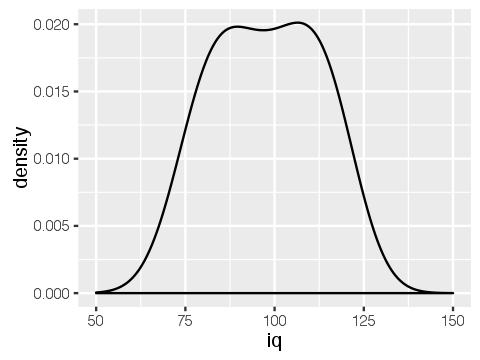

In [6]:
iq <- rnorm(n = 10, mean = 100, sd = 15)
df <- data.frame(iq = iq)
ggplot(df, aes(x = iq)) + geom_density() + xlim(c(50, 150))

#### As we increase the sample size, the distribution looks more like the theoretical one

Warning message:
: Removed 1 rows containing non-finite values (stat_density).

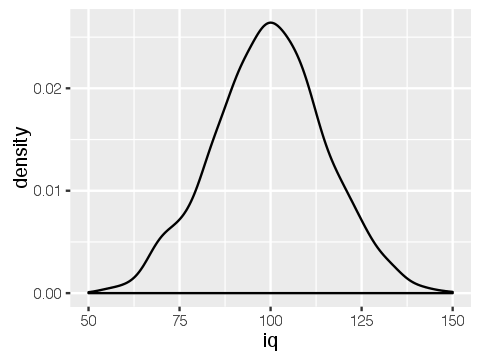

In [7]:
iq <- rnorm(n = 1000, mean = 100, sd = 15)
df <- data.frame(iq = iq)
ggplot(df, aes(x = iq)) + geom_density() + xlim(c(50, 150))

### Statistical simulations are a powerful tool to explore probability distributions

#### Use a simulation to find what fraction of the population has IQ > 120

See the effect of increasing sample size in the simulation on accuracy.

In [8]:
# Exact solution
round(1 - pnorm(120, mean = 100, sd = 15), 4)

[1] 0.0912

In [9]:
iq.sim <- function(iq, n, mean, sd) {
    x <- rnorm(n = n, mean = mean, sd = sd)
    round(sum(x > iq)/n, 4)
}

In [10]:
for (n in c(1e2, 1e3, 1e4, 1e5, 1e6)) {
    print(iq.sim(120, n, mean = 100, sd = 15))
}

[1] 0.13
[1] 0.081
[1] 0.094
[1] 0.0916
[1] 0.0913


#### Use a simulation to find out what IQ you need to be in the top 5% of the population

In [11]:
# Exact solution
qnorm(p = 0.95, mean = 100, sd = 15)

[1] 124.6728

In [12]:
x <- rnorm(1e6, mean = 100, sd = 15)
quantile(x, 0.95)

95% 
124.7025

### Fitting distributions to data

Suppose we are given some data. How do we fit a distribution to the data?

In [13]:
x <- read.table('duke_iqs.txt')

#### First just explore the data set

In [14]:
df <- data.frame(x=x)

In [15]:
summary(df)

       x         
 Min.   : 64.96  
 1st Qu.: 98.29  
 Median :111.66  
 Mean   :112.10  
 3rd Qu.:124.13  
 Max.   :173.46  

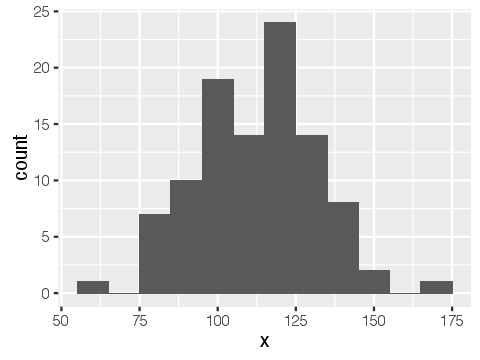

In [16]:
ggplot(df, aes(x=x)) + geom_histogram(binwidth = 10)

#### It seems from the histogram that a normal distribution might work

We will use maximum likelihood estimation to fit a normal distribution to the data using the `MASS` package.

In [17]:
library("MASS")

In [18]:
fit <- fitdistr(df$x, "normal")
fit$estimate

mean        sd 
112.10178  18.55804

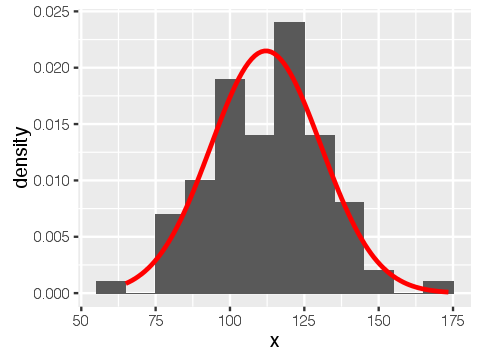

In [19]:
ggplot(df, aes(x=x)) + geom_histogram(aes(y = ..density..), binwidth = 10) +
  stat_function(fun = dnorm, args = fit$estimate, lwd = 1, col = 'red')

### Finding 95% confidence intervals for the estimate of the mean IQ

#### Assuming a normal distribution

In [20]:
n <- length(df$x)
mean <- fit$estimate[[1]]
sd <- fit$estimate[[2]]

error <- qnorm(0.975)*sd/sqrt(n)
ci <- c(mean - error, mean + error)
names(ci) <- c("2.5%", "97.5%")
ci

2.5%    97.5% 
108.4645 115.7391

#### Using bootstrap

If we don't want to make the assumption that the data fits a normal distribution (or have no idea how to calculate it), we can still estimate confidence intervals by `bootstrapping`.

In [21]:
nreps <- 10000
mus <- rep(NA, nreps)
for (i in 1:nreps) {
    mus[i] <- mean(sample(df$x, replace=TRUE))
}
quantile(mus, c(0.025, 0.975))

2.5%    97.5% 
108.5128 115.8283

## Work

The binomial distribution gives the expected number of "successes" in $n$ "trials" when the probability of success in any one trial $p$ is fixed. Since it is a count, it can only give on non-negative integers, and is therefore known as a **discrete** distribution, unlike the normal distribution which is a **continuous** distribution. We will illustrate by working through an exercise.

**1**. Suppose the average frequency of the `A` nucleotide in the human genome is 0.22. Plot a bar chart of the expected distribution of `A` found in a sequence of 20 nucleotides. Use the geometry `geom_bar(stat='identity')`.

**2**. What is the probability that you will find 10 or more `A` nucleotides? Do this 

- using `pbinom`
- using simulation with 1 million random samples (you will get 1 million numbers, each of which is the number of `A` nucleotides found in a random sequence of length 20).

**3**. What is the mode (most frequently found number) for the number of `A` nucleotides in a sequence of length 20? Do this

- by inspecting the bar plot
- by using `qbinom`
- by simulation with 1 million random samples 

By inspection, the mode is 4.

**4**. Write down what you think 5 random sequences of length 20 of the form `A---A--A-----AA---` where the expected frequency of `A` is 0.22 would look like. For example, two such sequences could be

```
---A---A----A--A---A
--A---A--A--A--A----
```

- Now use R to generate 20 random sequences of length 20 of the form `A---A--A-----AA---` where the expected frequency of `A` is 0.22. Once you have generated a vector $x$ of 20 characters (each is `A` or `-`), you can use `paste(x, sep="", collapse="")` to combine into a single string of length 20. 

- Do your imagined sequences look like the randomly generated ones?